In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

from hashlib import sha256
from random import sample

# Read datasets

The dataset used to test *STEED* was constructed from the following three files:
- **rating.csv**: this file contains the articles' ratings performed by the users of Epinions. The main information that was extracted is the *CONTENT_ID* (identifier of the article being rated), *MEMBER_ID* (identifier of the user that rated the article) and *RATING* (the evaluation of the article expressed as an integer between 0 and 5).
- **member_content.csv**: this file contains the subject of the article. The main information extracted are the *CONTENT_ID* (identifier of the article), *AUTHOR_ID* (identifier of the user that produced the article) and *SUBJECT* (the topic related to the produced article).
- **user_rating.csv**: this file contains the ratings performed by the users of Epinions towards other users. These ratings are not related to the articles being written but only to the behaviour of the user inside the platform. The main information extracted are *MY_ID* (identifier of the evaluator), *OTHER_ID* (identifier of the evaluated user) and *VALUE* (the evaluation score expressed as an integer that can be -1 or 1).

In [2]:
articles_review = pd.read_csv('./datasets inputs/rating.csv', names=['CONTENT_ID', 'MEMBER_ID', 'RATING', '1', '2', '3', '4', '5'], delimiter=',', dtype=object)
member_content = pd.read_csv('./datasets inputs/member_content.csv', names=['CONTENT_ID', 'AUTHOR_ID', 'SUBJECT'], delimiter=',', dtype=object)
user_rating = pd.read_csv('./datasets inputs/user_rating.csv', names=['MY_ID', 'OTHER_ID', 'VALUE', 'CREATION'], delimiter=',', dtype=object)

In [3]:
articles_review

,CONTENT_ID,MEMBER_ID,RATING,1,2,3,4,5
0,139431556,1312460676,5,0,2001/01/10,NaN,1,2518365.0
1,139431556,204358,5,0,2001/01/10,NaN,1,2518365.0
2,139431556,368725,5,0,2001/01/10,NaN,1,2518365.0
3,139431556,277629,5,0,2001/01/10,NaN,1,2518365.0
4,139431556,246386,5,0,2001/01/10,NaN,1,2518365.0
...,...,...,...,...,...,...,...,...
13668314,891503,311238,5,0,2001/01/10,2001/12/27,1,2522499.0
13668315,891503,210412,5,0,2001/01/10,2001/12/27,1,2522499.0
13668316,891503,351471,5,0,2001/01/10,2001/12/27,1,2522499.0
13668317,891503,394639,5,0,2001/01/10,2001/12/27,1,2522499.0


In [4]:
articles_review.drop(['1', '2', '3', '4', '5'], axis=1, inplace=True)

In [5]:
member_content

,CONTENT_ID,AUTHOR_ID,SUBJECT
0,1445595,220568,149003604865
1,1445596,717325,5303145344
2,1445597,360156,192620893057
3,1445598,718857,149002163073
4,1445600,513114,34252
...,...,...,...
1560138,113644637827,478558,226947339137
1560139,113644703363,478558,579633517441
1560140,113644768899,478558,262002480001
1560141,113644834435,478558,332026254209


In [6]:
user_rating

,MY_ID,OTHER_ID,VALUE,CREATION
0,3288305540,709420,1,2001/01/10
1,3290337156,204418,-1,2001/01/10
2,3294138244,269243,-1,2001/01/10
3,3294138244,170692484,-1,2001/01/10
4,3296759684,347967364,1,2001/01/10
...,...,...,...,...
841366,377602,75017588612,1,2003/08/12
841367,83329126276,203962,1,2003/08/12
841368,79757938564,1955106692,1,2003/08/12
841369,66846035844,399055,1,2003/08/12


In [7]:
user_rating.drop(['CREATION'], axis=1, inplace=True)

# Creating contexts layer

To create the context layer edges, we can exploit the *CONTENT_ID* index to merge both the **articles_review** and **member_content** files. The rating values are then scaled in a float value between 0 and 1. Since we do not need anymore the *CONTENT_ID* column we can drop it.

In [8]:
context_layer_edges = pd.merge(articles_review, member_content, on='CONTENT_ID')
context_layer_edges['RATING'] = context_layer_edges['RATING'].astype(int)
context_layer_edges['RATING'] = context_layer_edges['RATING'].apply(lambda v: (v / 10) * 2)
context_layer_edges.drop('CONTENT_ID', axis=1, inplace=True)
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,1312460676,1.0,2252443524,33578
1,204358,1.0,2252443524,33578
2,368725,1.0,2252443524,33578
3,277629,1.0,2252443524,33578
4,246386,1.0,2252443524,33578
...,...,...,...,...
13668098,311238,1.0,342187,342306558849
13668099,210412,1.0,342187,342306558849
13668100,351471,1.0,342187,342306558849
13668101,394639,1.0,342187,342306558849


Grouping the edges by the *SUBJECT* column, we then choose a subject of rows that is easier to handle while performing the tests both on the private and the public network.

In [9]:
context_layer_edges.groupby(by=['SUBJECT']).size().sort_values(ascending=False)[:10]

SUBJECT
6854272         244019
526227072       169371
462395008       131747
149004129153     78554
7640704          60366
460822144        46663
7509632          38159
6378             36767
6985344          35611
460691072        33910
dtype: int64

In [10]:
context_layer_edges.drop(context_layer_edges[(context_layer_edges.SUBJECT != "462395008")].index, inplace=True)
context_layer_edges.reset_index(drop=True, inplace=True)

In [11]:
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,446598,1.0,2654113668,462395008
1,3248852868,1.0,2654113668,462395008
2,532060,1.0,2654113668,462395008
3,447660,1.0,2654113668,462395008
4,294423,1.0,2654113668,462395008
...,...,...,...,...
131742,3034681220,0.6,249990,462395008
131743,477751,0.4,249990,462395008
131744,237466,0.8,310809,462395008
131745,355176,0.8,310809,462395008


In [12]:
context_layer_edges.groupby(by=['RATING']).size().sort_values(ascending=False)

RATING
1.0    117650
0.8     10794
0.4      1738
0.6      1528
0.2        37
dtype: int64

From the obtained dataframe, we extract the nodes (both issuers and generic nodes).

In [13]:
nodes = pd.DataFrame(columns=['ID'])
nodes['ID'] = pd.concat([context_layer_edges['MEMBER_ID'], context_layer_edges['AUTHOR_ID']], ignore_index=True)
nodes.drop_duplicates(inplace=True, ignore_index=True)
nodes

,ID
0,446598
1,3248852868
2,532060
3,447660
4,294423
...,...
7679,557256
7680,351892
7681,511576
7682,550452


# Creating issuers layer

The issuers' layer is built only by using the **user_rating.csv** file. All the negative values are transformed into zero values.

In [14]:
user_rating['VALUE'] = user_rating['VALUE'].astype(int)
user_rating.loc[user_rating['VALUE'] < 0, ['VALUE']] = 0
user_rating

,MY_ID,OTHER_ID,VALUE
0,3288305540,709420,1
1,3290337156,204418,0
2,3294138244,269243,0
3,3294138244,170692484,0
4,3296759684,347967364,1
...,...,...,...
841366,377602,75017588612,1
841367,83329126276,203962,1
841368,79757938564,1955106692,1
841369,66846035844,399055,1


The nodes of this layer will be only issuers, we exploit the previous data frame to extract the issuer nodes.

In [15]:
issuers = pd.DataFrame(columns=['ID'])
issuers['ID'] = context_layer_edges['AUTHOR_ID']
issuers.drop_duplicates(inplace=True, ignore_index=True)
issuers

,ID
0,2654113668
1,432034
2,439175
3,458079
4,531585
...,...
1268,447697
1269,388608
1270,550452
1271,433790


To retrieve only the edges between issuers, we filter by only getting edges that start from a node belonging to the issuers' layer and end in a node belonging to the issuers' layer.

In [16]:
issuer_layer_edges = user_rating.copy()
# get only edges between issuers
issuer_layer_edges = issuer_layer_edges[issuer_layer_edges['MY_ID'].isin(issuers['ID'])]
issuer_layer_edges = issuer_layer_edges[issuer_layer_edges['OTHER_ID'].isin(issuers['ID'])]
issuer_layer_edges.reset_index(drop=True, inplace=True)
issuer_layer_edges

,MY_ID,OTHER_ID,VALUE
0,233969,250714,1
1,239555,233981,1
2,239909,210284,1
3,239909,234885,1
4,239909,372535,1
...,...,...,...
31559,204418,243766,0
31560,399055,241578,1
31561,285020,261351,1
31562,480167,260251,1


# Creating entrypoints layer

This layer contains both nodes that belong to the contexts and issuers layers. To construct the edges dataframe, we are interested only in edges that start from a context node and end in an issuer node.

In [17]:
entrypoints_edges = user_rating.copy()
# get only edges between a generic node and an issuer
entrypoints_edges = entrypoints_edges[entrypoints_edges['MY_ID'].isin(nodes['ID'])]
entrypoints_edges = entrypoints_edges[entrypoints_edges['OTHER_ID'].isin(issuers['ID'])]
entrypoints_edges.reset_index(drop=True, inplace=True)
entrypoints_edges

,MY_ID,OTHER_ID,VALUE
0,237211524,265717,1
1,387092356,525103,1
2,409177988,312000,1
3,409177988,241374,1
4,409177988,266569,1
...,...,...,...
93258,355314,321708,1
93259,355314,394804,1
93260,562458,314690,0
93261,221363,261079,1


# Creating DIDs

The IDs of issuers and contexts are transformed in a DID following a similar procedure used by Hyperledger INDY.

In [18]:
nodes = nodes.applymap(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
nodes

,ID
0,did:indy:7755a39499f7d04f
1,did:indy:3bda9095ec61704f
2,did:indy:a426f6d4da858606
3,did:indy:f652a3fccb073d5f
4,did:indy:902902569dc4fd61
...,...
7679,did:indy:dae66bc6570499ac
7680,did:indy:e0050be00723e018
7681,did:indy:defee8487ddea7b6
7682,did:indy:b280130565e1cfc2


In [19]:
issuers = issuers.applymap(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuers

,ID
0,did:indy:edcb1ed9e115c81b
1,did:indy:f3c676e84d0aae80
2,did:indy:bb346e679d42306b
3,did:indy:0f9403aba6508451
4,did:indy:d3624ac5536e8be8
...,...
1268,did:indy:a48589a405a472c7
1269,did:indy:e23a95c45feaa868
1270,did:indy:016c91b843a56c14
1271,did:indy:37c342728e76f4a3


The same logic is performed for the issuers, contexts and entrypoints layer edges.

In [20]:
issuer_layer_edges['MY_ID'] = issuer_layer_edges['MY_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuer_layer_edges['OTHER_ID'] = issuer_layer_edges['OTHER_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
issuer_layer_edges

,MY_ID,OTHER_ID,VALUE
0,did:indy:f4483a66314388ba,did:indy:d38fc066b00b398b,1
1,did:indy:5151ed45b752ccaf,did:indy:924ded40ad336353,1
2,did:indy:e1096d451667fcee,did:indy:061347a6dda0334c,1
3,did:indy:e1096d451667fcee,did:indy:b423a6a525888741,1
4,did:indy:e1096d451667fcee,did:indy:a07005e2d9dce0ed,1
...,...,...,...
31559,did:indy:f3a4ef5489c2b458,did:indy:043f1cbc34643f56,0
31560,did:indy:df3838fbfaa007dc,did:indy:d039e4eac712e9b7,1
31561,did:indy:0e4c506ff190c7e5,did:indy:ceda698c3f80f6ff,1
31562,did:indy:60b8fe5af17c53ab,did:indy:b34150964bbd91da,1


In [21]:
context_layer_edges['MEMBER_ID'] = context_layer_edges['MEMBER_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
context_layer_edges['AUTHOR_ID'] = context_layer_edges['AUTHOR_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
context_layer_edges

,MEMBER_ID,RATING,AUTHOR_ID,SUBJECT
0,did:indy:7755a39499f7d04f,1.0,did:indy:e866974692a4b6fd,462395008
1,did:indy:3bda9095ec61704f,1.0,did:indy:e866974692a4b6fd,462395008
2,did:indy:a426f6d4da858606,1.0,did:indy:e866974692a4b6fd,462395008
3,did:indy:f652a3fccb073d5f,1.0,did:indy:e866974692a4b6fd,462395008
4,did:indy:902902569dc4fd61,1.0,did:indy:e866974692a4b6fd,462395008
...,...,...,...,...
131742,did:indy:defc25e22853dd46,0.6,did:indy:8952393785134940,462395008
131743,did:indy:a39f3e35f16f7a52,0.4,did:indy:8952393785134940,462395008
131744,did:indy:464198224a1f0348,0.8,did:indy:7a12e61370aba4ac,462395008
131745,did:indy:b994b2cd45305232,0.8,did:indy:7a12e61370aba4ac,462395008


In [22]:
entrypoints_edges['MY_ID'] = entrypoints_edges['MY_ID'].apply(lambda v: 'did:indy:' + sha256(('GENERIC-' + v).encode('utf-8')).hexdigest()[:16])
entrypoints_edges['OTHER_ID'] = entrypoints_edges['OTHER_ID'].apply(lambda v: 'did:indy:' + sha256(('ISSUERS-' + v).encode('utf-8')).hexdigest()[:16])
entrypoints_edges

,MY_ID,OTHER_ID,VALUE
0,did:indy:e9298fda42b5d880,did:indy:61971eff9e622e1a,1
1,did:indy:8c326a3c0673d474,did:indy:3cd8064ebf84bf32,1
2,did:indy:e0846bcd99762337,did:indy:aa0236a52dd89efd,1
3,did:indy:e0846bcd99762337,did:indy:7848646359635909,1
4,did:indy:e0846bcd99762337,did:indy:9e3ebc1ad487bfdc,1
...,...,...,...
93258,did:indy:55e1c8e2cd0d2ce5,did:indy:2cb52496e96cd10a,1
93259,did:indy:55e1c8e2cd0d2ce5,did:indy:cc8a3ac619291096,1
93260,did:indy:0d67d7139fca033c,did:indy:5dbea7a3438363df,0
93261,did:indy:13cfad8295f920ec,did:indy:ff42b8eb3c6376c0,1


# Graph analysis

From the dataframes we built the graphs by using the NetworkX package.

## Issuers graph

For the issuers graph, we indicate *MY_ID* as the source of the edge and *OTHER_ID* as the target of the edge. It is possible to specify also a weight to the edge, in this case we use the *VALUE* column. The graph is a *directed* graph.

In [23]:
issuers_graph = nx.from_pandas_edgelist(issuer_layer_edges, source='MY_ID', target='OTHER_ID',
                                        edge_attr='VALUE', create_using=nx.DiGraph())

In [24]:
in_degree_sequence_issuers = sorted(((n,d) for n, d in issuers_graph.in_degree()), reverse=True, key=lambda tup: tup[1])
in_degree_sequence_issuers[:15]

[('did:indy:061347a6dda0334c', 415),
 ('did:indy:a07005e2d9dce0ed', 263),
 ('did:indy:2e6255d751a92589', 262),
 ('did:indy:80fd7cf936f17214', 257),
 ('did:indy:f3a4ef5489c2b458', 250),
 ('did:indy:84031663e4adcc86', 232),
 ('did:indy:8f7ffa2b363a330e', 220),
 ('did:indy:cc8a3ac619291096', 205),
 ('did:indy:190993aa90e0a909', 202),
 ('did:indy:70c57ff644b58f24', 189),
 ('did:indy:b423a6a525888741', 181),
 ('did:indy:68e84c7e60ccbd85', 181),
 ('did:indy:6dd50900df39edb6', 174),
 ('did:indy:05e301ef2c130541', 170),
 ('did:indy:b2c90c8cda835e59', 169)]

In [25]:
list(filter(lambda t: t[1] >= 1, in_degree_sequence_issuers))[-15:]

[('did:indy:7f89e1f47a1536ef', 1),
 ('did:indy:18e471dff9caec25', 1),
 ('did:indy:a30d332e842b97ee', 1),
 ('did:indy:39e39080c2e5cfbe', 1),
 ('did:indy:2e8b632499f2a832', 1),
 ('did:indy:c3370232aa6b3349', 1),
 ('did:indy:43ad48ba765a3242', 1),
 ('did:indy:e23a95c45feaa868', 1),
 ('did:indy:073835fda24d04e1', 1),
 ('did:indy:8aeae2895838aee7', 1),
 ('did:indy:ef9f40765c4bd3be', 1),
 ('did:indy:3cbe6fb58c30a249', 1),
 ('did:indy:edcb1ed9e115c81b', 1),
 ('did:indy:7f99833952d49583', 1),
 ('did:indy:22a59dbb18d22a68', 1)]

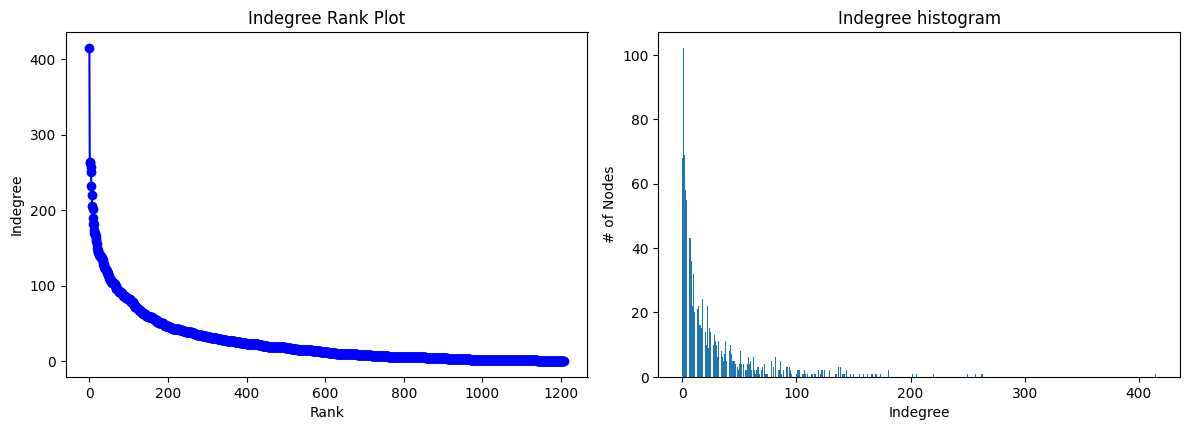

In [26]:
fig = plt.figure(figsize=(12, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(4, 4)
in_degree = sorted((d for n, d in issuers_graph.in_degree()), reverse=True)
"""
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc_issuers = issuers_graph.subgraph(sorted(nx.strongly_connected_components(issuers_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc_issuers, seed=10396953)
nx.draw_networkx_nodes(Gcc_issuers, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc_issuers, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()"""

ax1 = fig.add_subplot(axgrid[2:, :2])
ax1.plot(in_degree, "b-", marker="o")
ax1.set_title("Indegree Rank Plot")
ax1.set_ylabel("Indegree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[2:, 2:])
ax2.bar(*np.unique(in_degree, return_counts=True))
ax2.set_title("Indegree histogram")
ax2.set_xlabel("Indegree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Contexts graph

For the contexts graph, we indicate *MEMBER_ID* as the source of the edge and *AUTHOR_ID* as the target of the edge. It is possible to specify also a weight to the edge, in this case we use the *RATING* column. The graph is a *directed* graph.

In [27]:
contexts_graph = nx.from_pandas_edgelist(context_layer_edges, source='MEMBER_ID', target='AUTHOR_ID',
                                       edge_attr='RATING', create_using=nx.DiGraph())

In [28]:
out_degree_sequence_contexts = sorted(((n,d) for n, d in contexts_graph.out_degree()), reverse=True, key=lambda tup: tup[1])
out_degree_sequence_contexts[:15]

[('did:indy:fe9c69aaa1a77554', 459),
 ('did:indy:52a37a0b0a506e7f', 454),
 ('did:indy:182c136a6d753541', 448),
 ('did:indy:470d0d65a2461dc7', 445),
 ('did:indy:50305d98c72cb965', 392),
 ('did:indy:8cc3b356518c7888', 329),
 ('did:indy:bd1f7c4f98f9a74a', 321),
 ('did:indy:aab2e4647e9a5694', 316),
 ('did:indy:4e286c86f91db0a7', 304),
 ('did:indy:7649e16e01ca0264', 291),
 ('did:indy:877795bcd876cc32', 269),
 ('did:indy:3e114e8aafb1ba3a', 260),
 ('did:indy:242a01a06261db4e', 255),
 ('did:indy:96a1c9e410c7d5be', 248),
 ('did:indy:ef809bd4f80c479b', 245)]

In [29]:
list(filter(lambda t: t[1] >= 1, out_degree_sequence_contexts))[-15:]

[('did:indy:79d9ba325d6a4c47', 1),
 ('did:indy:b03306419c9d67e3', 1),
 ('did:indy:36202f36a2baf214', 1),
 ('did:indy:7a5c141e5d3a9ca0', 1),
 ('did:indy:d0996ee130cef92c', 1),
 ('did:indy:88fb927fae9d8ca8', 1),
 ('did:indy:136feed4643dce2e', 1),
 ('did:indy:8cfb74701a87c477', 1),
 ('did:indy:9733baa30fbd0eb3', 1),
 ('did:indy:6fc54f05be9ddca0', 1),
 ('did:indy:fc45abca04c8223f', 1),
 ('did:indy:cd112ef99d013baf', 1),
 ('did:indy:1daf0ec44464282c', 1),
 ('did:indy:971fc5f0d7e6c37a', 1),
 ('did:indy:f5c22eee592a9484', 1)]

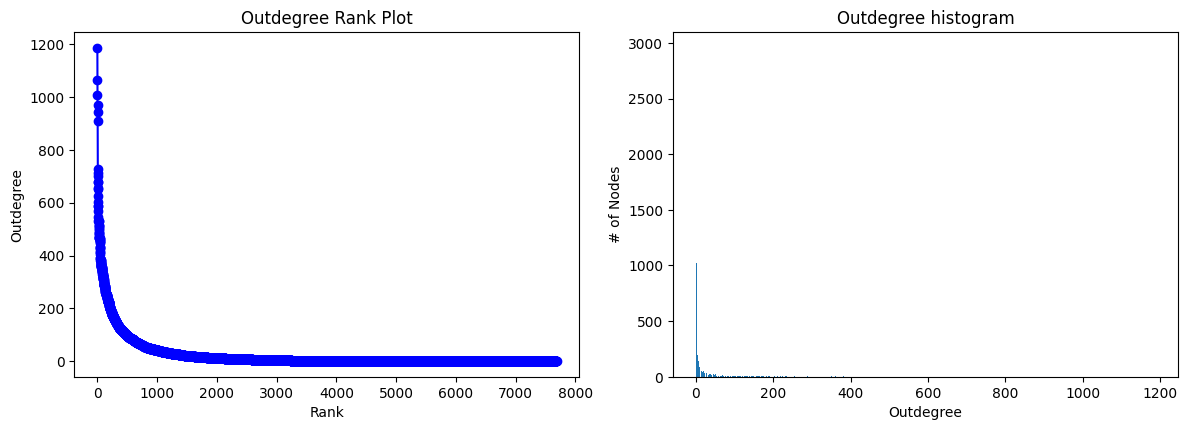

In [30]:
fig = plt.figure(figsize=(12, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(4, 4)
degree = sorted((d for n, d in contexts_graph.degree()), reverse=True)
"""
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc_contexts = contexts_graph.subgraph(sorted(nx.strongly_connected_components(issuers_graph), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc_contexts, seed=10396953)
nx.draw_networkx_nodes(Gcc_contexts, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc_contexts, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()"""

ax1 = fig.add_subplot(axgrid[2:, :2])
ax1.plot(degree, "b-", marker="o")
ax1.set_title("Outdegree Rank Plot")
ax1.set_ylabel("Outdegree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[2:, 2:])
ax2.bar(*np.unique(degree, return_counts=True))
ax2.set_title("Outdegree histogram")
ax2.set_xlabel("Outdegree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Entrypoints graph

For the entrypoints graph, we indicate *MY_ID* as the source of the edge and *OTHER_ID* as the target of the edge. It is possible to specify also a weight to the edge, in this case we use the *VALUE* column. The graph is a *directed* graph.

In [31]:
entrypoints_graph = nx.from_pandas_edgelist(entrypoints_edges, source='MY_ID', target='OTHER_ID',
                                       edge_attr='VALUE', create_using=nx.DiGraph())

## Whole graph

In NetworkX it is possible to compose multiple graphs.

In [32]:
whole_graph = nx.compose_all([contexts_graph, entrypoints_graph, issuers_graph])

In [33]:
print(whole_graph.number_of_edges())

216896


In [34]:
it = nx.all_simple_paths(whole_graph, 'did:indy:8cc3b356518c7888', 'did:indy:84031663e4adcc86', 3)

Using the out and in degree of contexts and issuer nodes, we extract the most "isolated" and most "popular" nodes. We also considered random issuers and contexts nodes.

In [35]:
last_50_contexts_nodes = list(filter(lambda t: t[1] >= 1, out_degree_sequence_contexts))[-50:]
last_50_issuers = list(filter(lambda t: t[1] >= 1, in_degree_sequence_issuers))[-50:]

In [36]:
first_50_contexts_nodes = [c[0] for c in out_degree_sequence_contexts[:50]]
first_50_issuers = [i[0] for i in in_degree_sequence_issuers[:50]]

In [40]:
random_issuer_nodes = sample(list(issuers_graph.nodes()), 1000)

In [41]:
random_context_nodes = sample(list(contexts_graph.nodes()), 1000)

## Creating the query dataset

To create the "isolated" query set we considered the most isolated nodes of both issuers and contexts layer.

In [42]:
isolated = pd.DataFrame({
    'SOURCE': [c[0] for c in last_50_contexts_nodes], 
    'TARGET': [i[0] for i in last_50_issuers],
    'CONTEXT': ['462395008' for i in range(0, 50)]
})
isolated

,SOURCE,TARGET,CONTEXT
0,did:indy:2b32f7d4f8502544,did:indy:5cbbb31fe64a040d,462395008
1,did:indy:951609f79125c59c,did:indy:982574bfde2079e9,462395008
2,did:indy:58de58949afeca32,did:indy:7cd18c71f55aaad3,462395008
3,did:indy:492d072f429bb988,did:indy:fb02e81c101e27ee,462395008
4,did:indy:77d7bd1eb0e1254c,did:indy:7f5553b3bda85304,462395008
5,did:indy:fe2a38daf84937c3,did:indy:c65732d4347b9f86,462395008
6,did:indy:304f3412863135af,did:indy:dcfe9ef3905671b8,462395008
7,did:indy:e0a79caa02ed88bc,did:indy:7ee76a0292c32da5,462395008
8,did:indy:c2a4c9449b07e097,did:indy:6613b39e9fe75442,462395008
9,did:indy:d69d13f661d47602,did:indy:4aa90d24e35c319f,462395008


To create the "popular" query set we considered the nodes with higher out and in degree of both issuers and contexts layer.

In [43]:
central = pd.DataFrame({
    'SOURCE': first_50_contexts_nodes[:50], 
    'TARGET': first_50_issuers[:50],
    'CONTEXT': ['462395008' for i in range(0, 50)]
})
central

,SOURCE,TARGET,CONTEXT
0,did:indy:fe9c69aaa1a77554,did:indy:061347a6dda0334c,462395008
1,did:indy:52a37a0b0a506e7f,did:indy:a07005e2d9dce0ed,462395008
2,did:indy:182c136a6d753541,did:indy:2e6255d751a92589,462395008
3,did:indy:470d0d65a2461dc7,did:indy:80fd7cf936f17214,462395008
4,did:indy:50305d98c72cb965,did:indy:f3a4ef5489c2b458,462395008
5,did:indy:8cc3b356518c7888,did:indy:84031663e4adcc86,462395008
6,did:indy:bd1f7c4f98f9a74a,did:indy:8f7ffa2b363a330e,462395008
7,did:indy:aab2e4647e9a5694,did:indy:cc8a3ac619291096,462395008
8,did:indy:4e286c86f91db0a7,did:indy:190993aa90e0a909,462395008
9,did:indy:7649e16e01ca0264,did:indy:70c57ff644b58f24,462395008


To create the random query set we do not consider the indegree or outdegree.

In [44]:
random = pd.DataFrame({
    'SOURCE': random_context_nodes, 
    'TARGET': random_issuer_nodes,
    'CONTEXT': ['462395008' for i in range(0, 1000)]
})

# Output datasets creation

In [45]:
nodes.to_csv('./datasets outputs/nodes.csv', index=False)
issuers.to_csv('./datasets outputs/issuers.csv', index=False)
issuer_layer_edges.to_csv('./datasets outputs/issuer_layer_edges.csv', index=False)
context_layer_edges.to_csv('./datasets outputs/context_layer_edges.csv', index=False)
entrypoints_edges.to_csv('./datasets outputs/entrypoints_edges.csv', index=False)
isolated.to_csv('./datasets outputs/isolated.csv', index=False)
central.to_csv('./datasets outputs/central.csv', index=False)
random.to_csv('./datasets outputs/random.csv', index=False)